# Special Notes on Evaluation

This is an especially tricky task, to test the flexibility of the interpretability methods. I want to check whether I'm able to get correct explanations of the differences if they are in a ring shape as can be seen in a scatter plot of $x_2$ over $x_1$.

The interpretability methods should give explanations on two levels:
- global level
    - for optimal selectiveness, it should consist of only one rule with 4 constraints and include both instances classified $(1,0)$ and $(1,1)$, thus being low on metric precision. But it should not be low on metric recall.
- local level
    - each interpretability method should describe as accurately as necessary. The explanation should not make compromises on metric precision anymore.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from util import calc_ground_truth_constraints, constraint_matrix_to_rules
from clustering import make_clustering
from tasks.gaussian_quantiles import make_task

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

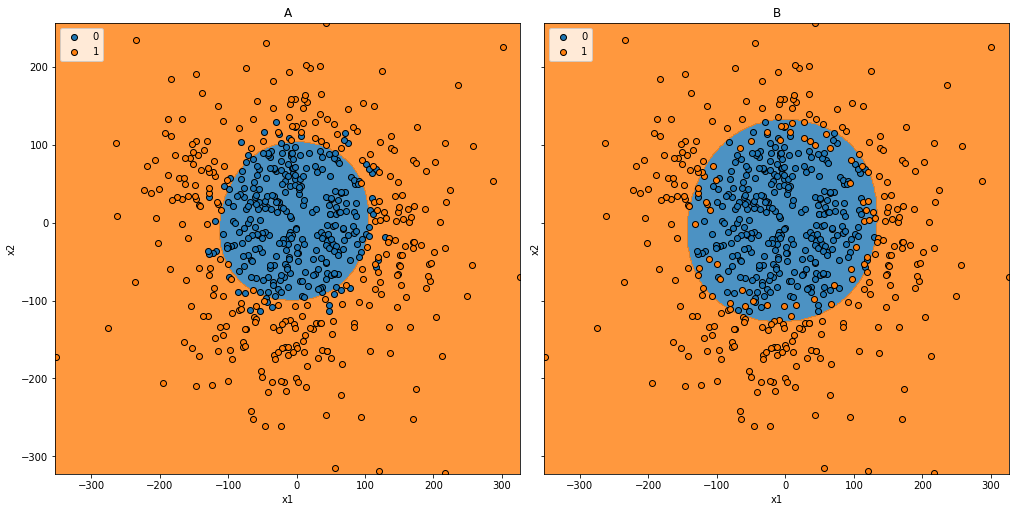

In [5]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', mesh_step_size=1)

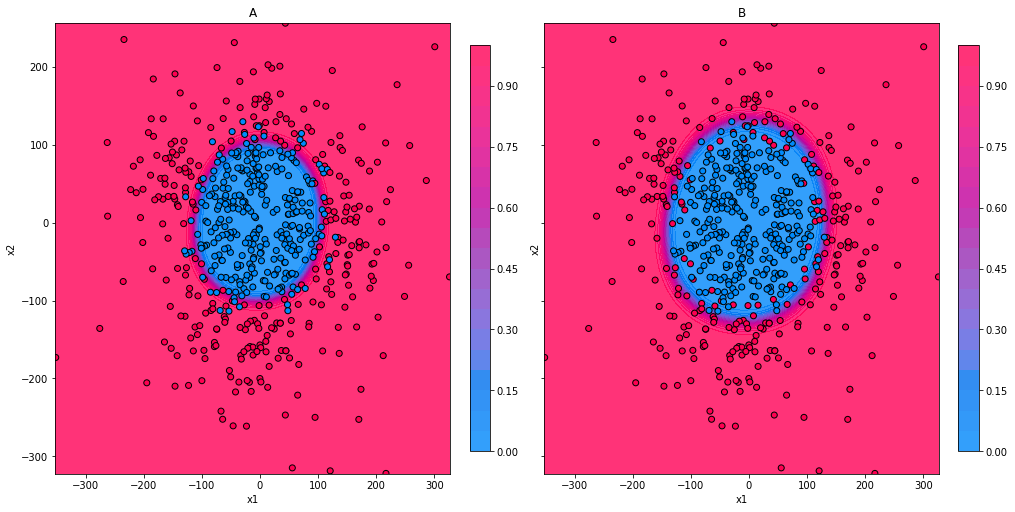

In [6]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='proba', mesh_step_size=1)

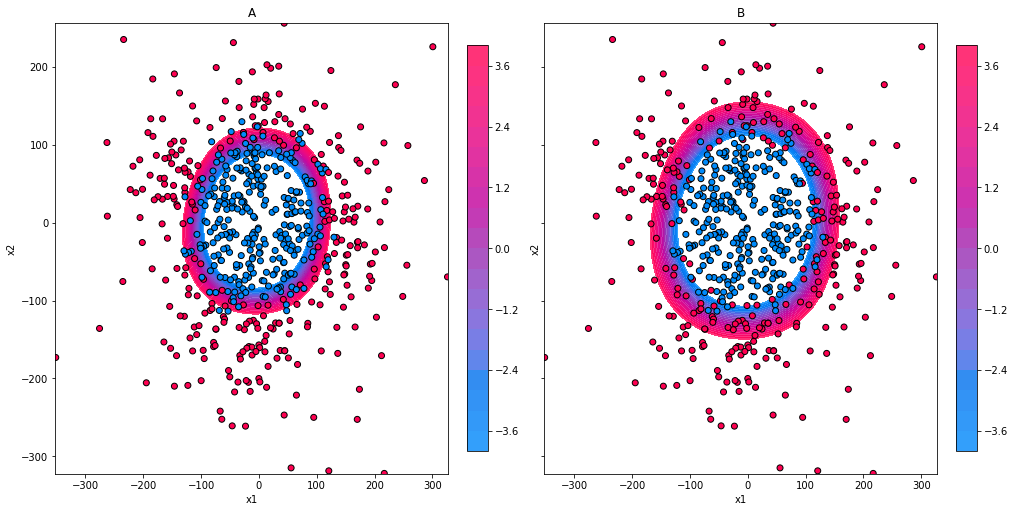

In [7]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='log-odds', mesh_step_size=1)

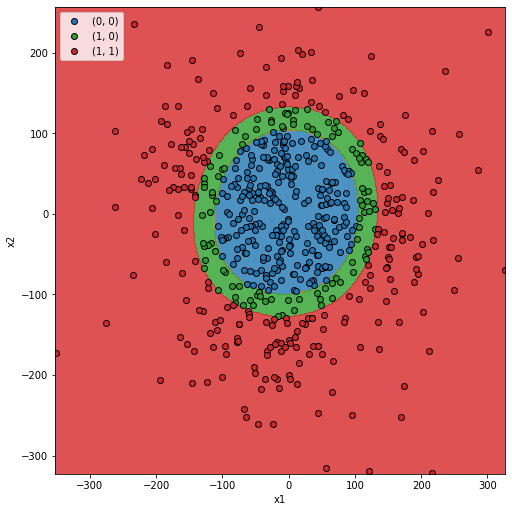

In [8]:
comparer.plot_decision_boundaries(X, mesh_step_size=1)

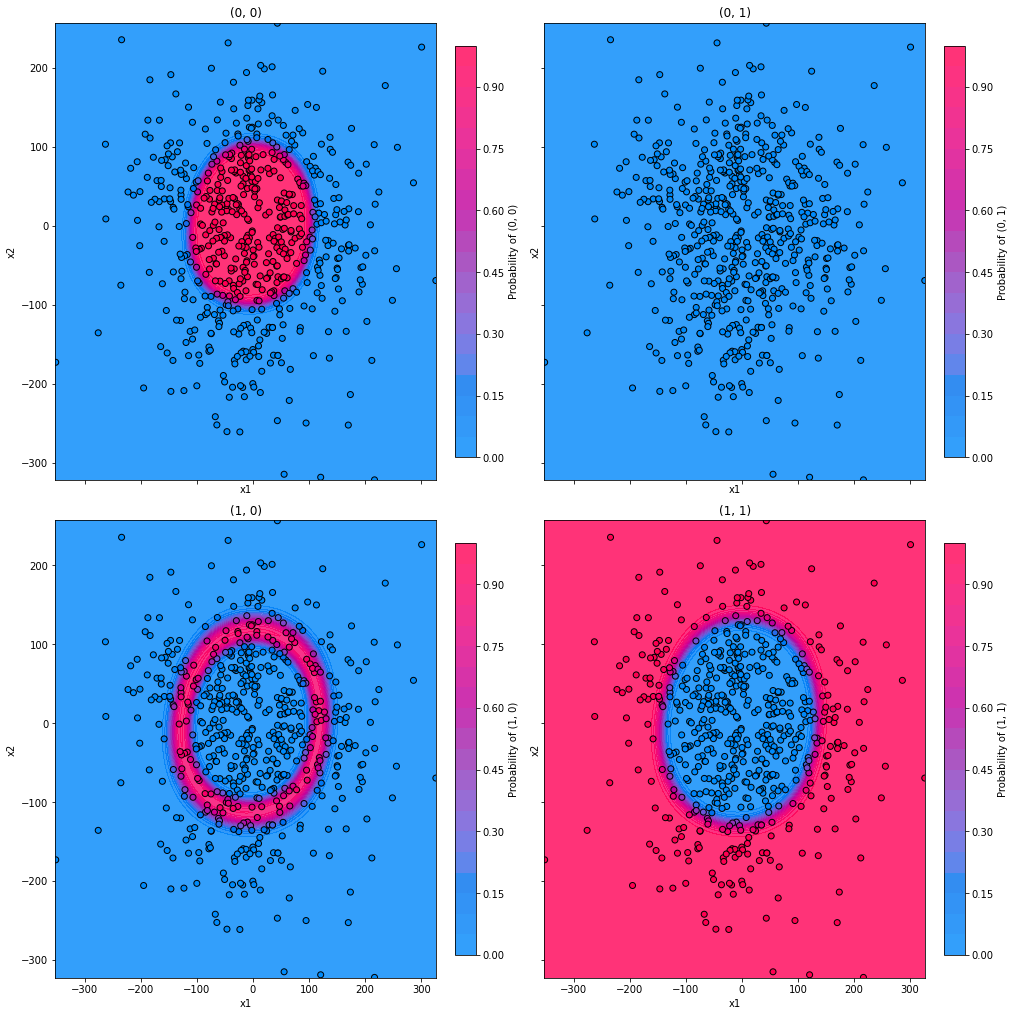

In [9]:
comparer.plot_decision_boundaries(X, kind='proba', mesh_step_size=1)

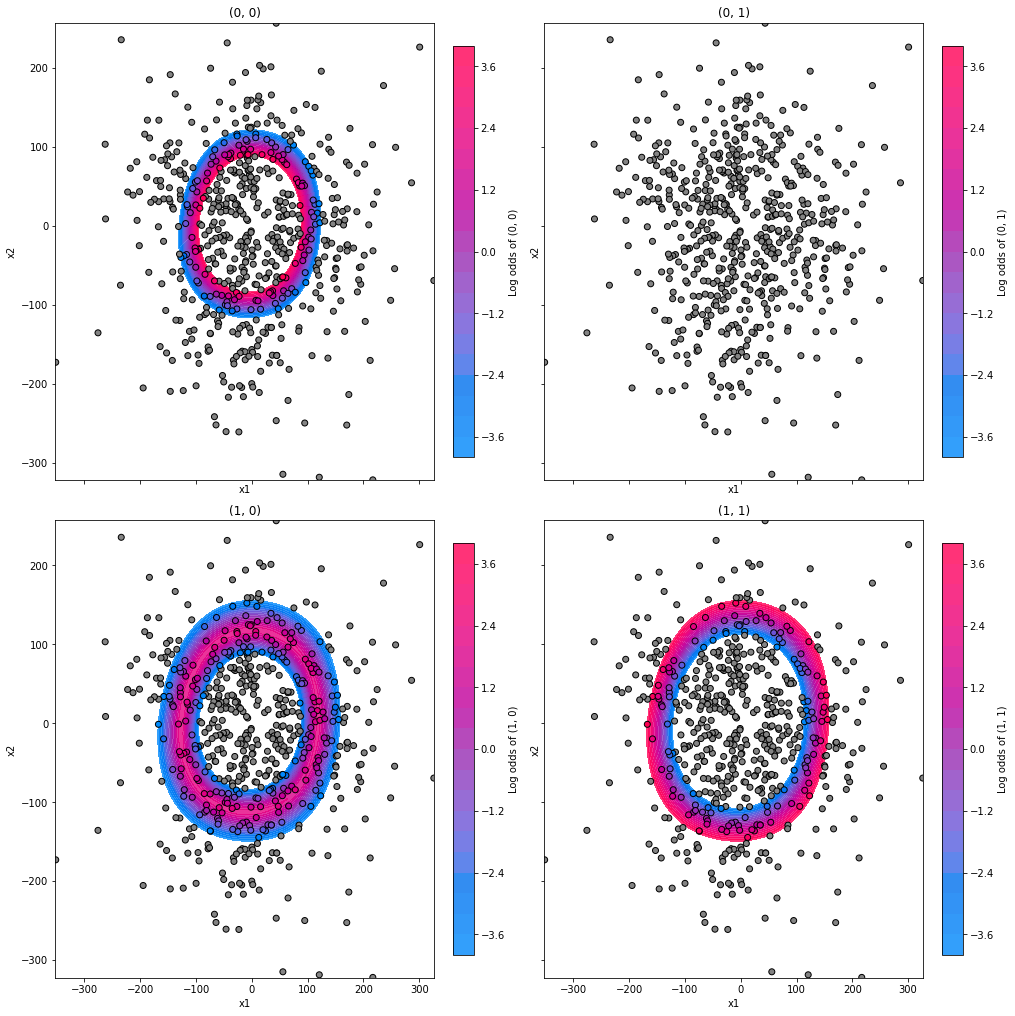

In [10]:
comparer.plot_decision_boundaries(X, kind='log-odds', mesh_step_size=1)

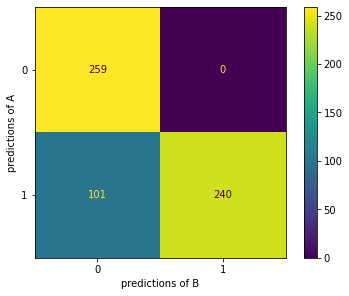

In [11]:
comparer.plot_confusion_matrix(X)

# Ground Truth

In [12]:
%%time
for label in comparer.difference_class_names:
    print(label)
    ground_truth_instance_indices, ground_truth = calc_ground_truth_constraints(comparer, feature_precisions, X, label)
    with open(f'ground_truth.{label}.pickle', 'wb') as f:
        pickle.dump((ground_truth_instance_indices, ground_truth), f)
    rules = constraint_matrix_to_rules(ground_truth, feature_names)
    for instance_idx, rule in zip(ground_truth_instance_indices, rules):
        print(f'{instance_idx}: {rule}')
    print()

(0, 1)

(1, 0)
150: -90.5 < x1 <= 73.5 and -127.2 < x2 <= -99.8
151: -91.4 < x1 <= 74.4 and -125.8 < x2 <= -98.2
152: 99.2 < x1 <= 129.1 and -82.3 < x2 <= -19.7
153: -83.9 < x1 <= 87.6 and 103.7 < x2 <= 132.3
155: 13.0 < x1 <= 85.1 and -120.2 < x2 <= -91.1
156: 63.2 < x1 <= 104.4 and -107.6 < x2 <= -73.4
158: 34.8 < x1 <= 96.6 and 97.1 < x2 <= 127.3
159: -91.9 < x1 <= 74.9 and -126.4 < x2 <= -98.4
160: -86.6 < x1 <= 90.2 and 99.3 < x2 <= 128.9
161: -99.7 < x1 <= 82.6 and -123.1 < x2 <= -93.8
162: -140.7 < x1 <= -109.6 and 12.7 < x2 <= 81.3
163: -80.6 < x1 <= 84.3 and 101.3 < x2 <= 130.5
164: 84.3 < x1 <= 117.9 and -89.4 < x2 <= -40.2
166: 105.2 < x1 <= 134.1 and -66.4 < x2 <= 79.4
167: -127.1 < x1 <= -92.9 and 40.3 < x2 <= 91.8
168: 45.0 < x1 <= 100.1 and 86.4 < x2 <= 119.6
169: -86.3 < x1 <= 90.0 and 93.2 < x2 <= 124.4
170: -69.2 < x1 <= 72.5 and 103.8 < x2 <= 132.4
171: 103.5 < x1 <= 133.0 and -68.0 < x2 <= 80.9
172: -97.0 < x1 <= -43.6 and 83.2 < x2 <= 117.3
173: -138.9 < x1 <= -107

# Comparing Prediction Spaces

In [12]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [13]:
%%time
indiv_shap_values_labels = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
indiv_shap_values_proba = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='proba')
indiv_shap_values_log_odds = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values_labels = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
diffclf_shap_values_proba = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='proba')
diffclf_shap_values_log_odds = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.labels.shap', 'wb') as f:
    pickle.dump(indiv_shap_values_labels, f, pickle.HIGHEST_PROTOCOL)
with open('indiv.proba.shap', 'wb') as f:
    pickle.dump(indiv_shap_values_proba, f, pickle.HIGHEST_PROTOCOL)
with open('indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values_log_odds, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.labels.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values_labels, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.proba.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values_proba, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values_log_odds, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 601it [01:19,  7.24it/s]                         
Exact explainer: 601it [00:58,  8.38it/s]                         
Exact explainer: 601it [01:01,  8.05it/s]                         
Exact explainer: 601it [00:56,  9.04it/s]                         
Exact explainer: 601it [00:58,  8.41it/s]                         
Exact explainer: 601it [01:00,  8.18it/s]                         


CPU times: user 5min 48s, sys: 3.86 s, total: 5min 52s
Wall time: 6min 14s


# Traditional SHAP Explanations

## Labels

In [14]:
with open('indiv.labels.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [15]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

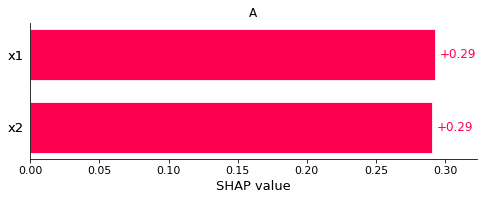

In [16]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

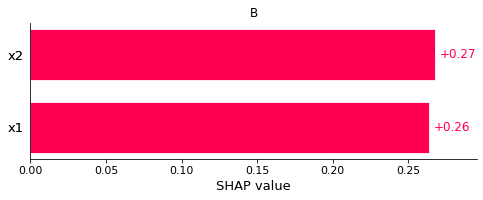

In [17]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

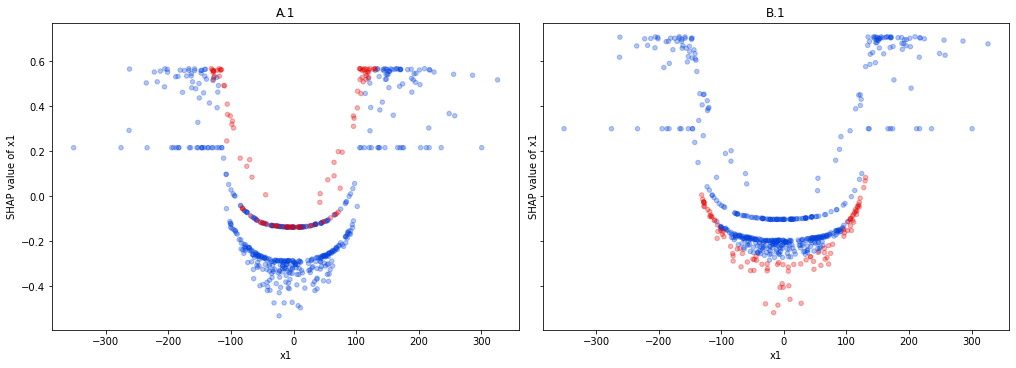

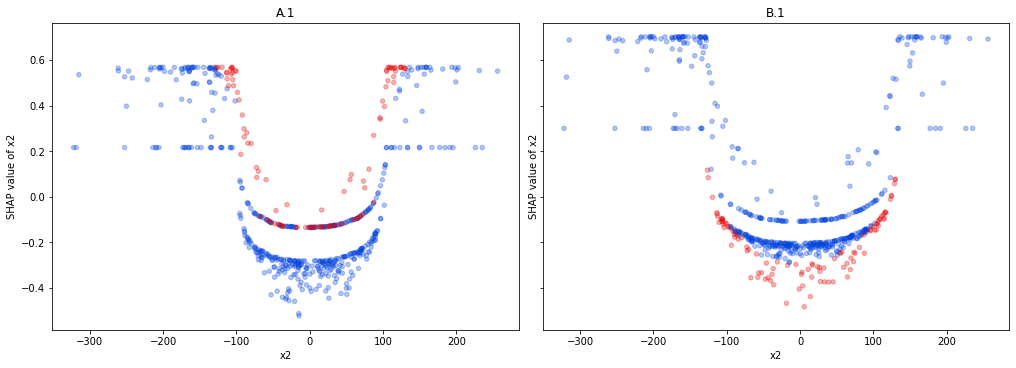

In [18]:
node = make_clustering(comparer, indiv_shap_values)
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Probability

In [19]:
with open('indiv.proba.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [20]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

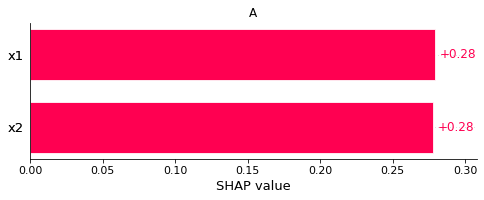

In [21]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

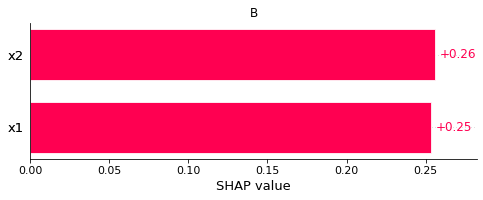

In [22]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

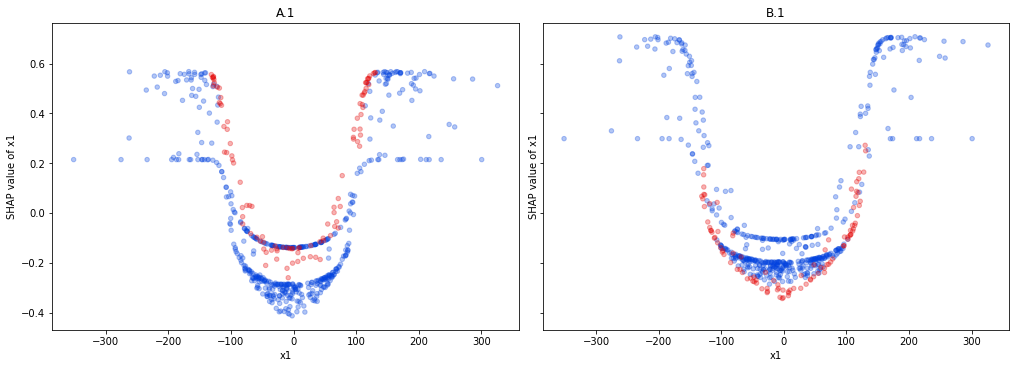

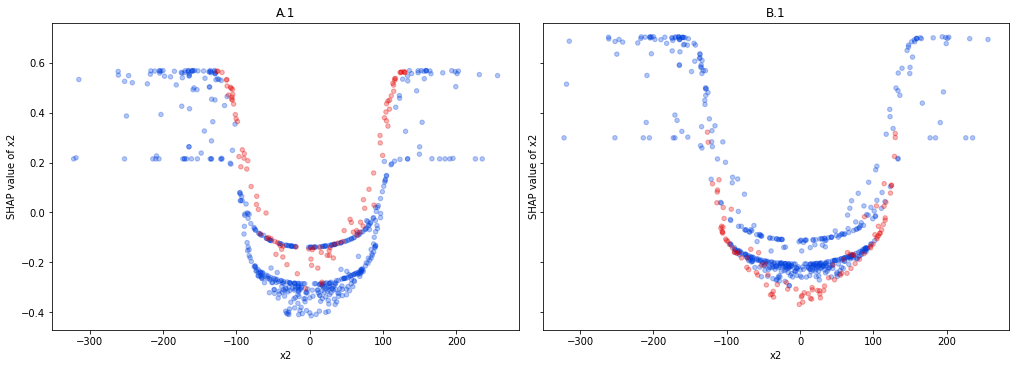

In [23]:
node = make_clustering(comparer, indiv_shap_values)
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Log Odds

In [24]:
with open('indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [25]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

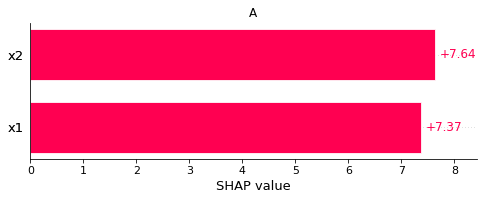

In [26]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

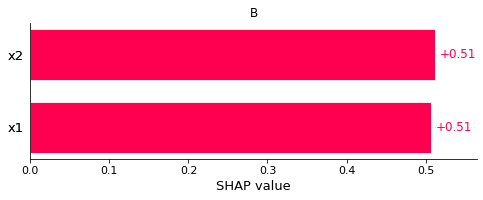

In [27]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

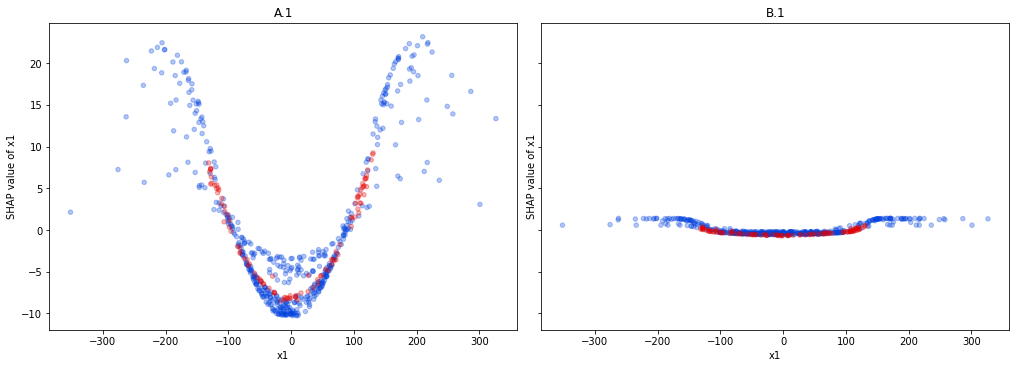

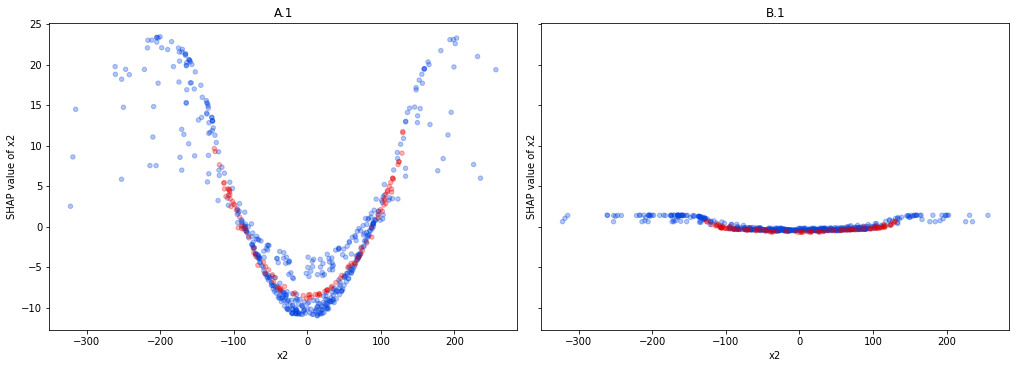

In [28]:
node = make_clustering(comparer, indiv_shap_values)
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

# Difference Classifier SHAP Explanations

## Labels

In [29]:
with open('diffclf.labels.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

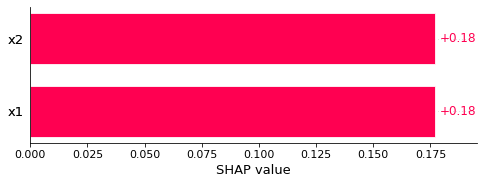

In [30]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

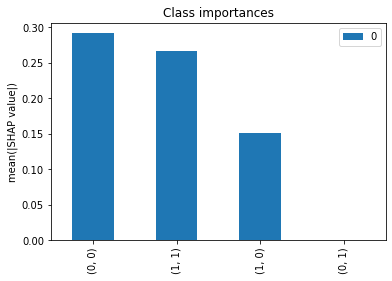

In [31]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

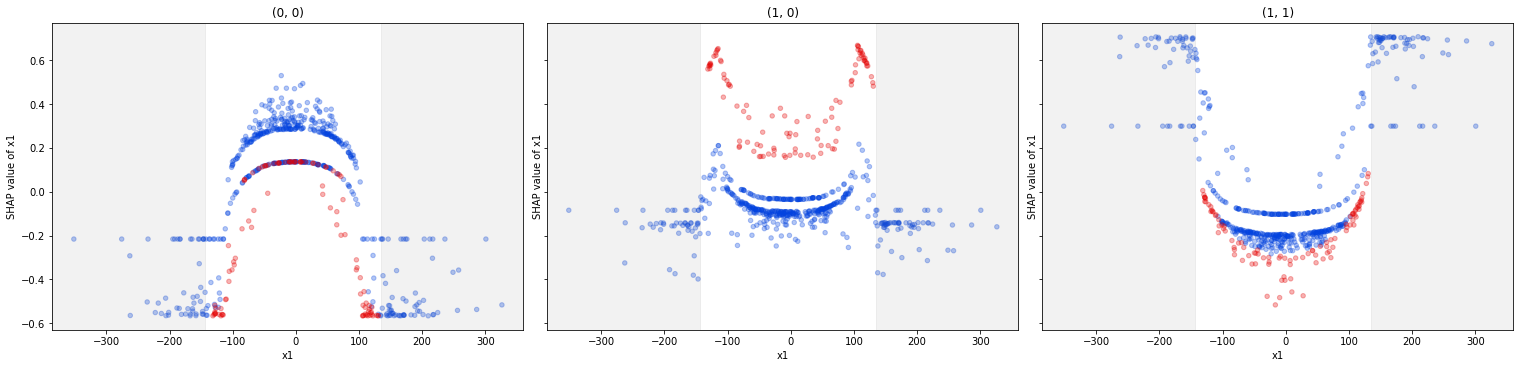

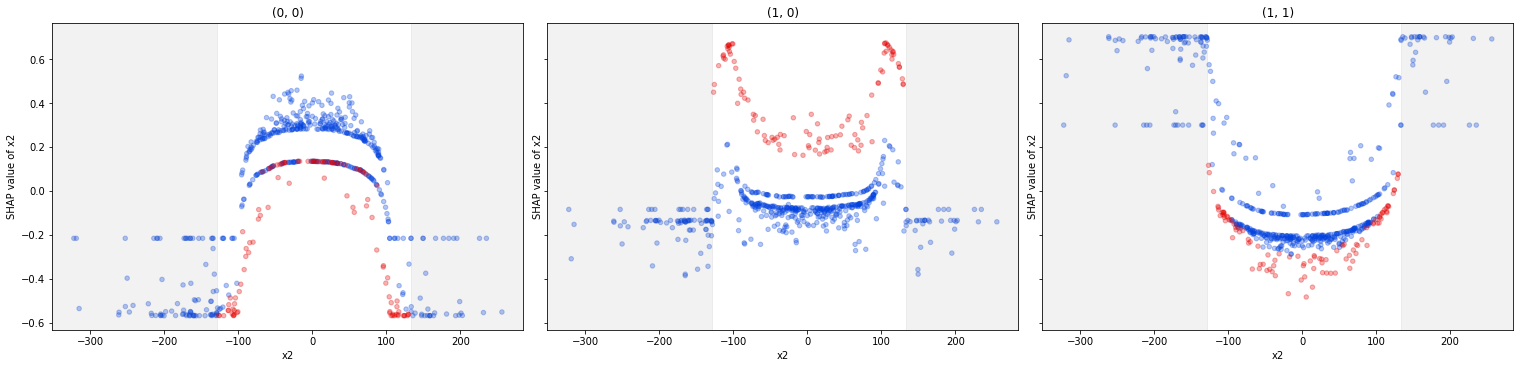

In [32]:
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Probability

In [33]:
with open('diffclf.proba.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

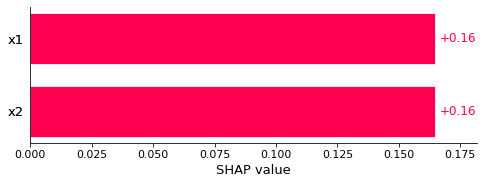

In [34]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

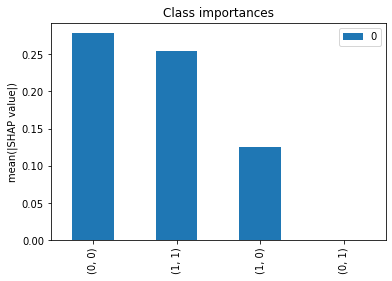

In [35]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

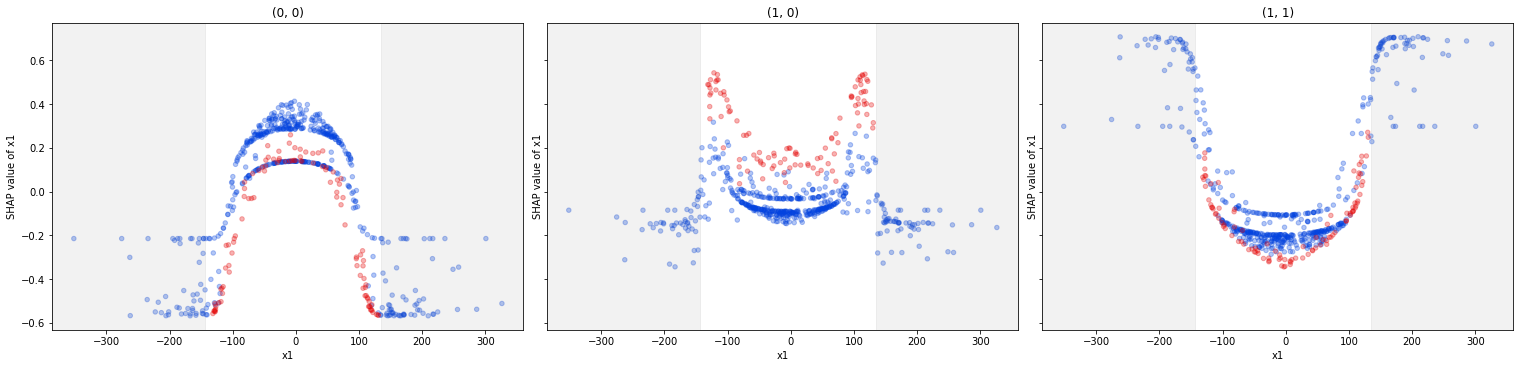

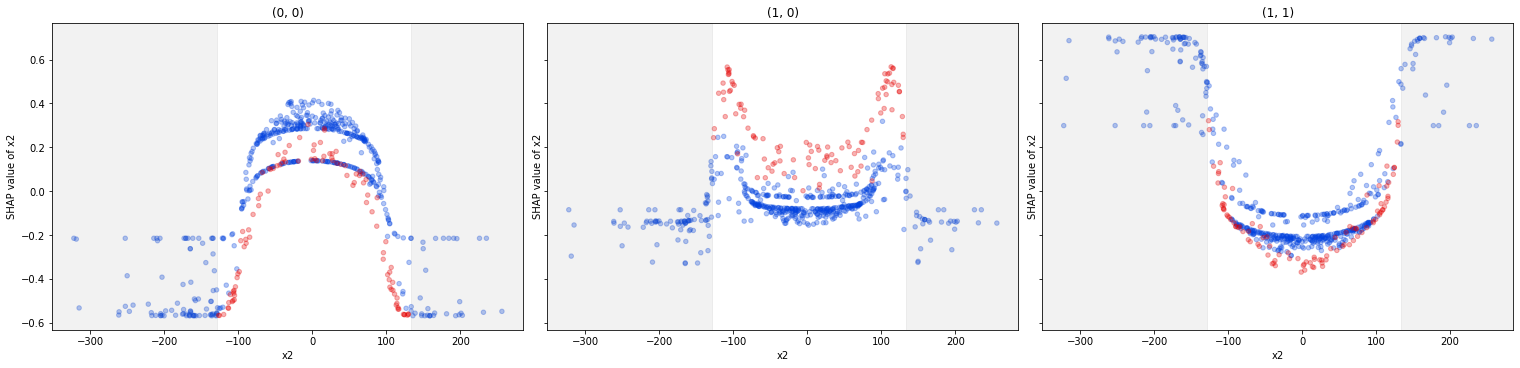

In [36]:
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)

## Log Odds

In [37]:
with open('diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

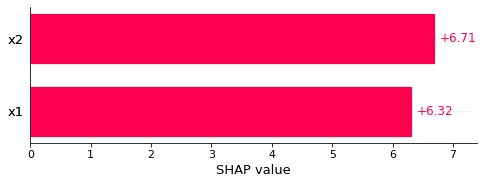

In [38]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

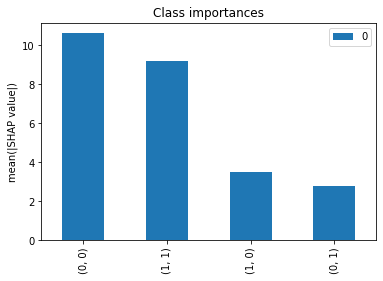

In [39]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

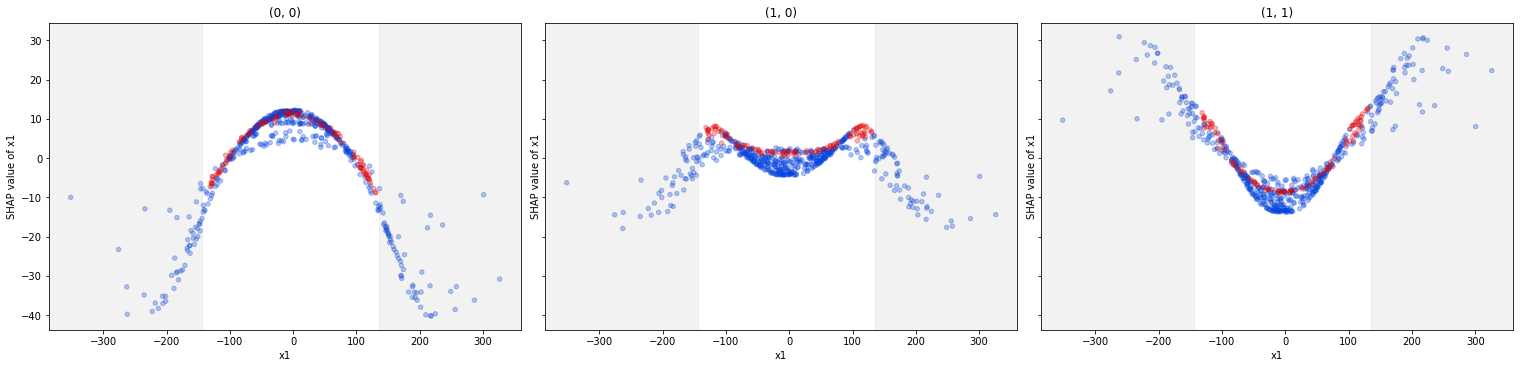

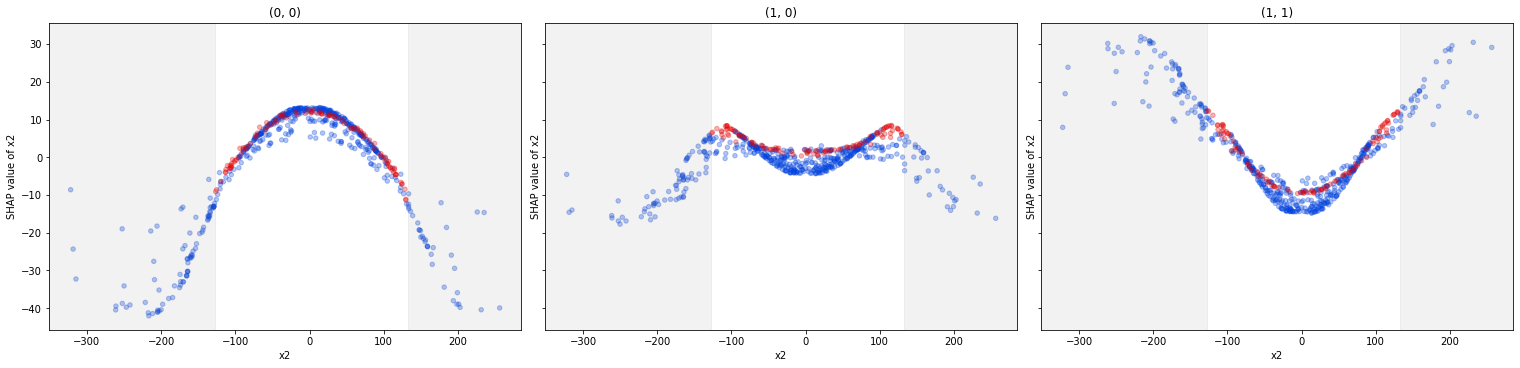

In [40]:
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
for feature in comparer.feature_names:
    node.plot_feature_dependence(feature, alpha=0.3)